<a href="https://colab.research.google.com/github/Aarthykannan/ak/blob/main/Frozen_dessert_LSTMproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [25]:
# Project Tasks

# **TASK: Read in the data set "Frozen_Dessert_Production.csv" from the Data folder. Figure out how to set the date to a datetime index columns**

In [8]:
df = pd.read_csv('/content/Frozen_Dessert_Production.csv',index_col = 'DATE',parse_dates = True)

In [9]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


In [11]:
df.columns = ['production']

In [12]:
df.head(2)

,production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605


<Axes: xlabel='DATE'>

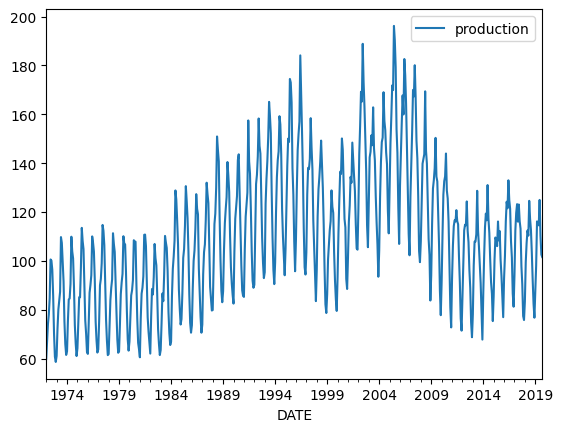

In [13]:
df.plot()

In [14]:
len(df)

573

In [16]:
test_size = 24
train_size = len(df) - 24

In [17]:
train_size

549

In [18]:
train = df.iloc[ :train_size]
test = df.iloc[train_size: ]

In [20]:
# test

In [21]:
from sklearn.preprocessing import MinMaxScaler

In [22]:
mm = MinMaxScaler()
train_sc = mm.fit_transform(train)
test_sc = mm.transform(test)

In [23]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator as tsg

In [26]:
length = 12
gen = tsg(train_sc,train_sc,length = length,batch_size=1)

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [28]:
# We're only using one feature in our time series
n_features = 1

In [29]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [31]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [33]:
validation_generator = tsg(test_sc,test_sc, length=length, batch_size=1)

In [34]:
# fit model
model.fit_generator(gen,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20


<ipython-input-34-fc4a5e396491>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(gen,epochs=20,


537/537 [==============================] - 6s 9ms/step - loss: 0.0206 - val_loss: 0.0046
Epoch 2/20
537/537 [==============================] - 5s 10ms/step - loss: 0.0078 - val_loss: 0.0022
Epoch 3/20
537/537 [==============================] - 6s 11ms/step - loss: 0.0064 - val_loss: 0.0022
Epoch 4/20
537/537 [==============================] - 7s 12ms/step - loss: 0.0042 - val_loss: 0.0021
Epoch 5/20
537/537 [==============================] - 5s 9ms/step - loss: 0.0043 - val_loss: 0.0020
Epoch 6/20
537/537 [==============================] - 6s 11ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 7/20
537/537 [==============================] - 5s 10ms/step - loss: 0.0035 - val_loss: 0.0054
Epoch 8/20
537/537 [==============================] - 4s 8ms/step - loss: 0.0033 - val_loss: 0.0023


In [35]:
losses = pd.DataFrame(model.history.history)

<Axes: >

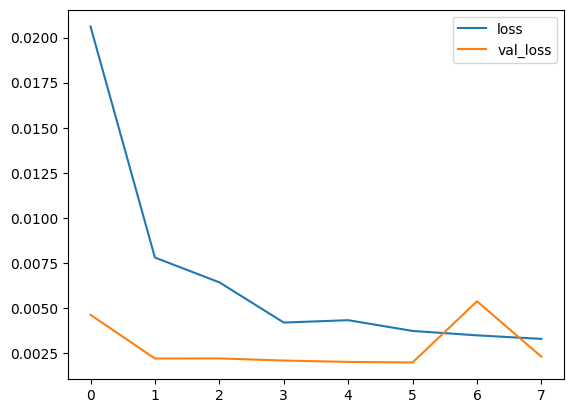

In [36]:
losses.plot()

In [37]:
test_predictions = []

first_eval_batch = train_sc[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]

    # store prediction
    test_predictions.append(current_pred)

    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 26ms/step


In [38]:
true_predictions = mm.inverse_transform(test_predictions)

In [39]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

<ipython-input-39-53e06c23926f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [40]:
test

,production,Predictions
DATE,,
2017-10-01,90.4732,97.009549
2017-11-01,77.4378,92.717648
2017-12-01,75.8118,93.770236
2018-01-01,83.4343,102.360162
2018-02-01,99.4899,112.547023
2018-03-01,107.3152,121.147408
2018-04-01,112.4309,127.318286
2018-05-01,110.3544,130.646970
2018-06-01,124.5841,130.856070


<Axes: xlabel='DATE'>

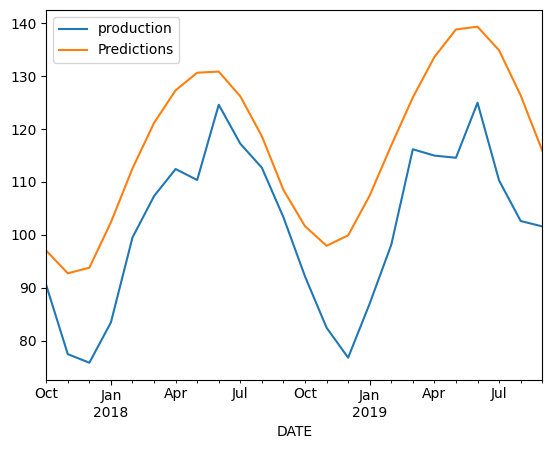

In [42]:
test.plot()

In [43]:
# FORECAST

df_sc = mm.fit_transform(df)

In [44]:
gen_df = tsg(df_sc,df_sc,length = length,batch_size=1)

In [46]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit_generator(gen,epochs=8)

Epoch 1/8


<ipython-input-46-9a59b911acdc>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(gen,epochs=8)


537/537 [==============================] - 6s 8ms/step - loss: 0.0250
Epoch 2/8
537/537 [==============================] - 4s 8ms/step - loss: 0.0071
Epoch 3/8
537/537 [==============================] - 4s 8ms/step - loss: 0.0051
Epoch 4/8
537/537 [==============================] - 4s 7ms/step - loss: 0.0048
Epoch 5/8
537/537 [==============================] - 6s 11ms/step - loss: 0.0051
Epoch 6/8
537/537 [==============================] - 8s 16ms/step - loss: 0.0043
Epoch 7/8
537/537 [==============================] - 4s 8ms/step - loss: 0.0038
Epoch 8/8
537/537 [==============================] - 4s 8ms/step - loss: 0.0042


In [59]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 18

first_eval_batch = df_sc[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]

    # store prediction
    forecast.append(current_pred)

    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 34ms/step


In [60]:
forecast = mm.inverse_transform(forecast)

In [61]:
df.tail(5)

,production
DATE,
2019-05-01,114.5613
2019-06-01,124.9605
2019-07-01,110.2632
2019-08-01,102.6085
2019-09-01,101.5866


In [62]:
forecast_index = pd.date_range(start ='2019-10-01',periods=periods,freq='MS' )

In [56]:
forecast_df = pd.DataFrame(data=forecast,index = forecast_index,columns=['forecast'])

<Axes: >

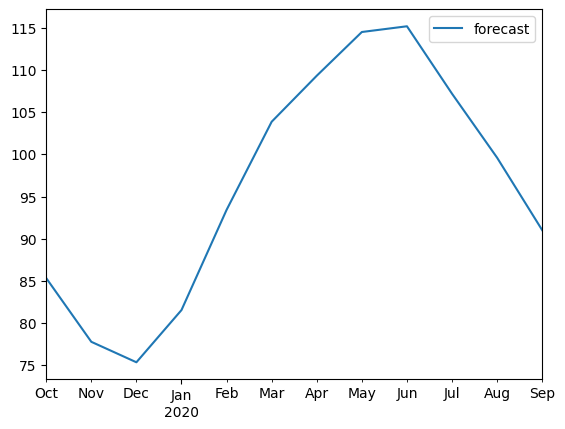

In [57]:
forecast_df.plot()

(585.0, 609.0)

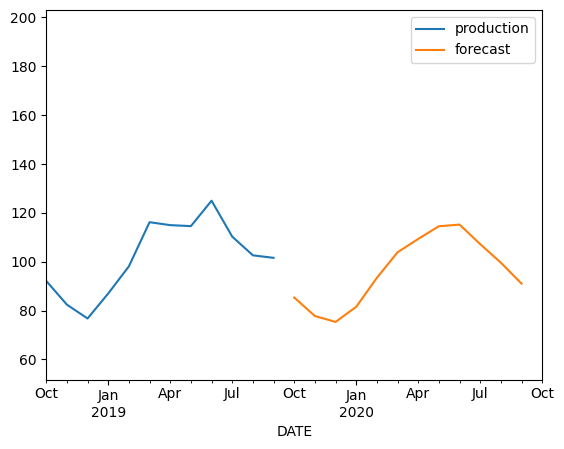

In [58]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-10-01','2020-10-01')